In [174]:
import uproot
import glob
import numpy as np
import pandas as pd
from matplotlib import colors
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rc('font', size=18)

In [175]:
cms4_df = ((uproot.open("output/ttbar_cms4_0.root")).get("tree")).pandas.df()

nano_df = []
for nano_baby in glob.glob("output/ttbar_nano_*"):
    nano_df.append(((uproot.open(nano_baby)).get("tree")).pandas.df())
nano_df = pd.concat(nano_df)

In [176]:
cms4_df.shape

(243424, 19)

In [177]:
nano_df.shape

(235739, 15)

In [178]:
cms4_events_in_nano = np.isin(cms4_df.event, nano_df.event)
nano_events_in_cms4 = np.isin(nano_df.event, cms4_df.event)

In [179]:
np.sum(cms4_events_in_nano)

235739

In [180]:
np.sum(nano_events_in_cms4)

235739

In [181]:
cms4_df.columns

Index([u'leader_eta', u'lagger_isTriggerSafe', u'leader_isTriggerSafe',
       u'lagger_id', u'leader_id', u'lagger_idx', u'leader_idx',
       u'leader_is_loose', u'lagger_is_loose', u'leader_is_tight',
       u'lagger_is_tight', u'lagger_eta', u'hyp_class', u'leader_pt',
       u'lagger_pt', u'is_dilepton_event', u'event', u'run', u'lumi'],
      dtype='object')

In [182]:
np.sum(cms4_df.is_dilepton_event)

20033

In [183]:
np.sum(nano_df.is_dilepton_event)

5732

In [184]:
synch_df = nano_df.merge(cms4_df, on="event", how="inner", suffixes=("_nano","_cms4"))

In [185]:
cms4_synch_df = cms4_df.sort_values("event")
nano_synch_df = nano_df[np.isin(nano_df.event, cms4_synch_df.event)].sort_values("event")

In [210]:
def hyp_class_hist(df, label="", fmt="bs", ignore_misses=True, log=False, 
                   fig=None, axes=None):
    if not fig or not axes:
        fig = plt.figure(figsize=(6.4,6.4))
        axes = plt.subplot(111)
    bin_edges = np.arange(0,9)
    # Get histogram values
    counts, _ = np.histogram(df.hyp_class, bins=bin_edges)
    # Get bin dimensions
    bin_widths = bin_edges[1:]-bin_edges[:-1]
    bin_centers = bin_edges[:-1]+0.5*bin_widths
    # Plot error bars
    if ignore_misses:
        bin_edges = bin_edges[1:]
        bin_widths = bin_widths[1:]
        counts = counts[1:]
    axes.errorbar(bin_edges[:-1], counts, xerr=0.5*bin_widths,
                  fmt=fmt, label=label);
    axes.margins(x=0) # Remove axis margins
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    # Plot formatting
    plt.xticks(np.arange(1,8));
    if log:
        plt.yscale('log')
    return

def hyp_synch_plot(cms4_synch_df, nano_synch_df, 
                   flav=None, ignore_misses=True,
                   cms4_label="CMS4", nano_label="Nano"):
    # Set up figure
    fig = plt.figure(figsize=(6.4*2.25,6.4))
    # Set up labels
    ticks = np.arange(0,8)
    labels = ["None","LL", "LT | TL", "TT", "OS TT", "inSitu", r"Z | $\gamma*$", "OS inSitu"]
    if ignore_misses:
        ticks = ticks[1:]
        labels = labels[1:]
    
    # Lin plot
    axes1 = plt.subplot(121)
    hyp_class_hist(cms4_synch_df, label=cms4_label, fmt="bs", 
                   ignore_misses=ignore_misses, log=False, 
                   fig=fig, axes=axes1)
    hyp_class_hist(nano_synch_df, label=nano_label, fmt="ro", 
                   ignore_misses=ignore_misses, log=False, 
                   fig=fig, axes=axes1)
    # Formatting
    plt.legend();
    plt.title("Hyp Comparison (linscale)");
    plt.xticks(ticks, labels, rotation="45", ha="right");
    plt.ylabel("Events");
    plt.grid(which="both");

    # Log plot
    axes2 = plt.subplot(122)
    hyp_class_hist(cms4_synch_df, label=cms4_label, fmt="bs", 
                   log=True, fig=fig, axes=axes2)
    hyp_class_hist(nano_synch_df, label=nano_label, fmt="ro", 
                   log=True, fig=fig, axes=axes2)
    # Formatting
    plt.legend();
    plt.title("Hyp Comparison (logscale)");
    plt.xticks(ticks, labels, rotation="45", ha="right")
    plt.ylabel("Events");
    plt.grid(which="both");
    
def hyp_pt_plot(cms4_df, nano_df, hyp=1, flav=(None, None),
                cms4_label="CMS4", nano_label="Nano", title=False):
    # Get synch events
    hyp_synch_events = (np.isin(nano_df.event,
                                cms4_df[cms4_df.hyp_class == hyp].event))
    # Get synch dfs
    cms4_synch_df = cms4_df[cms4_df.hyp_class == hyp]
    nano_synch_df = nano_df[hyp_synch_events]
    
    # Lepton flavor filters
    leader_flav, lagger_flav = flav
    nano_filter = nano_synch_df.is_dilepton_event
    cms4_filter = cms4_synch_df.is_dilepton_event
    if leader_flav:
        nano_leader_filter = (nano_synch_df.leader_id.abs() == leader_flav)
        cms4_leader_filter = (cms4_synch_df.leader_id.abs() == leader_flav)
        nano_filter = (nano_filter & nano_leader_filter)
        cms4_filter = (cms4_filter & cms4_leader_filter)
    if lagger_flav:
        nano_lagger_filter = (nano_synch_df.lagger_id.abs() == lagger_flav)
        cms4_lagger_filter = (cms4_synch_df.lagger_id.abs() == lagger_flav)
        nano_filter = (nano_filter & nano_lagger_filter)
        cms4_filter = (cms4_filter & cms4_lagger_filter)
        
    # Set up figure
    fig = plt.figure(figsize=(6.4*2.25,4.8))
    if title:
        flav_title = ""
        for f in flav:
            if not f:
                flav_title += "\ell "
            elif abs(f) == 11:
                flav_title += "e"
            elif abs(f) == 13:
                flav_title += "\mu "
            
        fig.suptitle(r"Kinematics for ${}$ events".format(flav_title))

    # Left plot (leaders)
    axes1 = plt.subplot(121)
    plt.hist(cms4_synch_df[cms4_filter].leader_pt, 
             bins=np.linspace(0,250,26),
             color="b", alpha=0.5, label=cms4_label);
    plt.hist(nano_synch_df[nano_filter].leader_pt, 
             bins=np.linspace(0,250,26),
             color="r", alpha=0.5, label=nano_label);
    # Formatting
    axes1.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$p_{T}^{leading}$");
    plt.ylabel("Events");
    plt.legend();

    # Right plot (laggers)
    axes2 = plt.subplot(122)
    plt.hist(cms4_synch_df[cms4_filter].lagger_pt, 
             bins=np.linspace(0,250,26),
             color="b", alpha=0.5, label=cms4_label);
    plt.hist(nano_synch_df[nano_filter].lagger_pt, 
             bins=np.linspace(0,250,26),
             color="r", alpha=0.5, label=nano_label);
    # Formatting
    axes2.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$p_{T}^{trailing}$");
    plt.ylabel("Events");
    plt.legend();
    
def hyp_eta_plot(cms4_df, nano_df, hyp=1, flav=(None,None),
                 cms4_label="CMS4", nano_label="Nano", title=""):
    # Get synch events
    hyp_synch_events = (np.isin(nano_df.event,
                                cms4_df[cms4_df.hyp_class == hyp].event))
    # Get synch dfs
    cms4_synch_df = cms4_df[cms4_df.hyp_class == hyp]
    nano_synch_df = nano_df[hyp_synch_events]
    
    # Lepton flavor filters
    leader_flav, lagger_flav = flav
    nano_filter = nano_synch_df.is_dilepton_event
    cms4_filter = cms4_synch_df.is_dilepton_event
    if leader_flav:
        nano_leader_filter = (nano_synch_df.leader_id.abs() == leader_flav)
        cms4_leader_filter = (cms4_synch_df.leader_id.abs() == leader_flav)
        nano_filter = (nano_filter & nano_leader_filter)
        cms4_filter = (cms4_filter & cms4_leader_filter)
    if lagger_flav:
        nano_lagger_filter = (nano_synch_df.lagger_id.abs() == lagger_flav)
        cms4_lagger_filter = (cms4_synch_df.lagger_id.abs() == lagger_flav)
        nano_filter = (nano_filter & nano_lagger_filter)
        cms4_filter = (cms4_filter & cms4_lagger_filter)
    
    # Set up figure
    fig = plt.figure(figsize=(6.4*2.25,4.8))
    if title:
        fig.suptitle(title)

    # Left plot (leaders)
    axes1 = plt.subplot(121)
    plt.hist(cms4_synch_df[cms4_filter].leader_eta, 
             bins=np.linspace(-2.5,2.5,11),
             color="b", alpha=0.5, label=cms4_label);
    plt.hist(nano_synch_df[nano_filter].leader_eta, 
             bins=np.linspace(-2.5,2.5,11),
             color="r", alpha=0.5, label=nano_label);
    # Formatting
    axes1.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$\eta^{leading}$");
    plt.ylabel("Events");
    plt.legend();

    # Right plot (laggers)
    axes2 = plt.subplot(122)
    plt.hist(cms4_synch_df[cms4_filter].lagger_eta, 
             bins=np.linspace(-2.5,2.5,11),
             color="b", alpha=0.5, label=cms4_label);
    plt.hist(nano_synch_df[nano_filter].lagger_eta, 
             bins=np.linspace(-2.5,2.5,11),
             color="r", alpha=0.5, label=nano_label);
    # Formatting
    axes2.xaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$\eta^{trailing}$");
    plt.ylabel("Events");
    plt.legend();

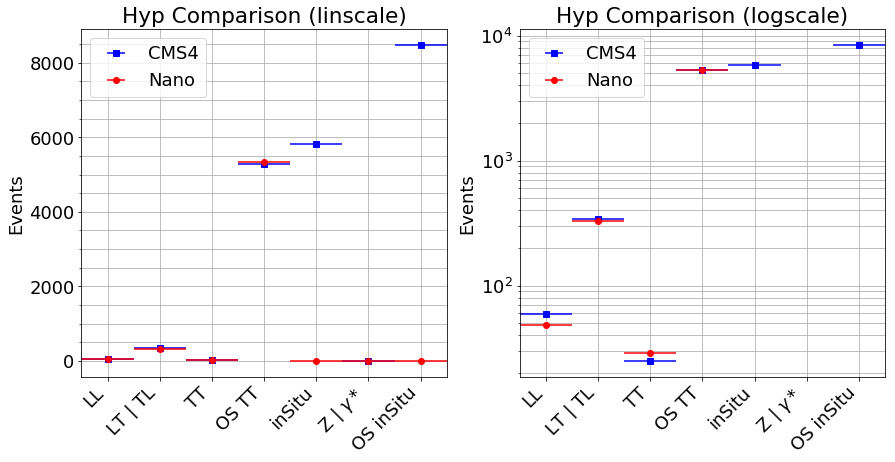

In [211]:
hyp_synch_plot(cms4_synch_df, nano_synch_df)

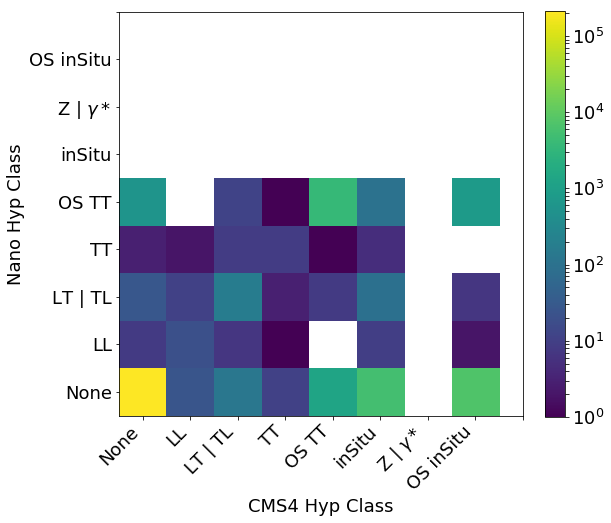

In [225]:
fig = plt.figure(figsize=(6.4*1.25,6.4*1.25))
axes = plt.subplot(111)
axes.set_aspect('equal')

hyp2d_counts,_,_,_ = plt.hist2d(synch_df.hyp_class_cms4, synch_df.hyp_class_nano, 
                                bins=np.arange(0,9)-0.5,
                                norm=colors.LogNorm());
plt.colorbar(fraction=0.0455);

plt.xticks(np.arange(0,9), 
           ["None","LL", "LT | TL", "TT", "OS TT", "inSitu", r"Z | $\gamma*$", "OS inSitu"],
           rotation="45", ha="right");
plt.xlabel("CMS4 Hyp Class");

plt.yticks(np.arange(0,9), 
           ["None","LL", "LT | TL", "TT", "OS TT", "inSitu", r"Z | $\gamma*$", "OS inSitu"]);
plt.ylabel("Nano Hyp Class");

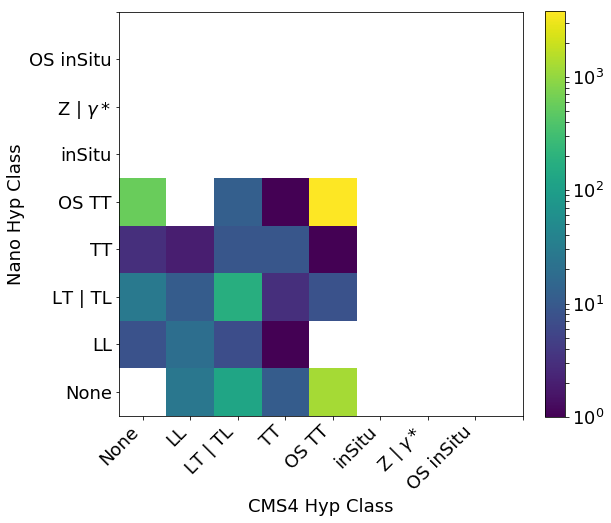

In [247]:
# Suppress CMS4 & Nano misses
hyp2d_counts[0,0] = 0.0
# Remove CMS4 inSitu
hyp2d_counts[5,:] *= 0.0
hyp2d_counts[7,:] *= 0.0

fig = plt.figure(figsize=(6.4*1.25,6.4*1.25))
axes = plt.subplot(111)
axes.set_aspect('equal')
c = axes.pcolorfast(np.arange(0,9)-0.5, np.arange(0,9)-0.5, 
                    hyp2d_counts.T, norm=colors.LogNorm())
cbar = fig.colorbar(c, ax=axes, fraction=0.0455);

plt.xticks(np.arange(0,9), 
           ["None","LL", "LT | TL", "TT", "OS TT", "inSitu", r"Z | $\gamma*$", "OS inSitu"],
           rotation="45", ha="right");
plt.xlabel("CMS4 Hyp Class");

plt.yticks(np.arange(0,9), 
           ["None","LL", "LT | TL", "TT", "OS TT", "inSitu", r"Z | $\gamma*$", "OS inSitu"]);
plt.ylabel("Nano Hyp Class");

In [189]:
# loose-loose
hyp1_synch_events = (np.isin(nano_synch_df.event,
                             cms4_synch_df[cms4_synch_df.hyp_class == 1].event))
# loose&!tight-tight | tight-loose&!tight
hyp2_synch_events = (np.isin(nano_synch_df.event,
                             cms4_synch_df[cms4_synch_df.hyp_class == 2].event))
# tight-tight
hyp3_synch_events = (np.isin(nano_synch_df.event,
                             cms4_synch_df[cms4_synch_df.hyp_class == 3].event))
# opposite sign tight-tight
hyp4_synch_events = (np.isin(nano_synch_df.event,
                             cms4_synch_df[cms4_synch_df.hyp_class == 4].event))
# Z or gamma*
hyp6_synch_events = (np.isin(nano_synch_df.event,
                             cms4_synch_df[cms4_synch_df.hyp_class == 6].event))

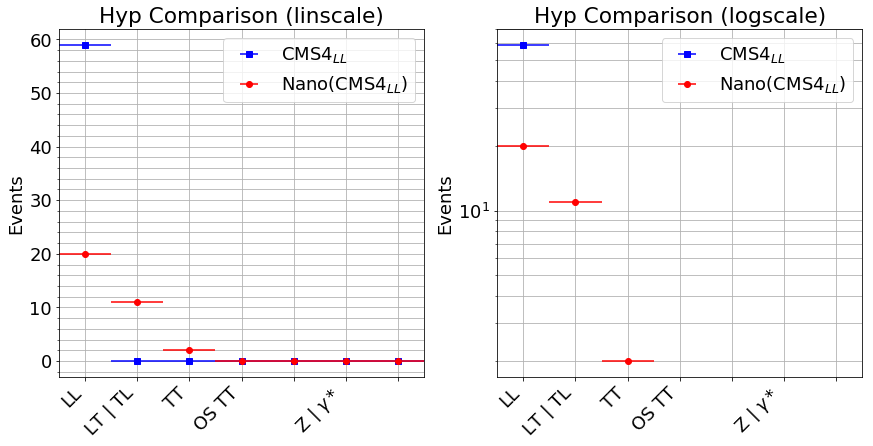

In [190]:
hyp_synch_plot(cms4_synch_df[cms4_synch_df.hyp_class == 1], 
               nano_synch_df[hyp1_synch_events],
               cms4_label=r"CMS4$_{LL}$",
               nano_label=r"Nano(CMS4$_{LL}$)")

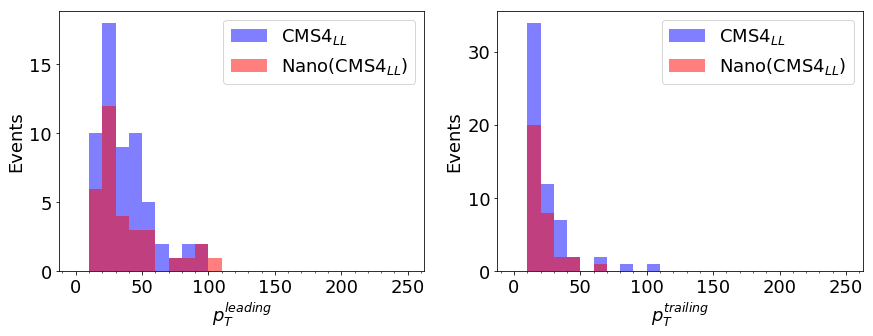

In [191]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=1,
            cms4_label=r"CMS4$_{LL}$",
            nano_label=r"Nano(CMS4$_{LL}$)")

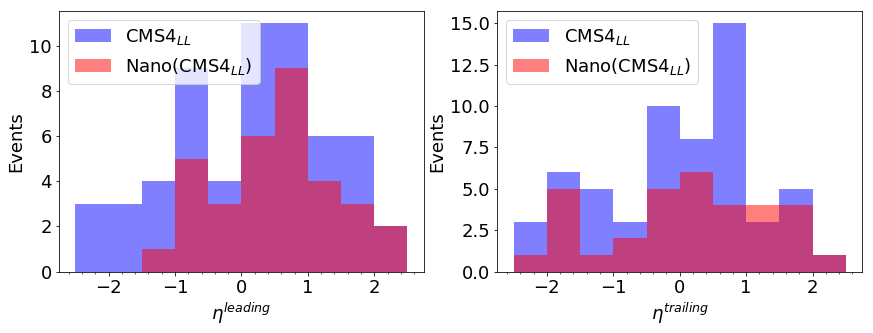

In [192]:
hyp_eta_plot(cms4_synch_df, nano_synch_df, hyp=1,
             cms4_label=r"CMS4$_{LL}$",
             nano_label=r"Nano(CMS4$_{LL}$)")

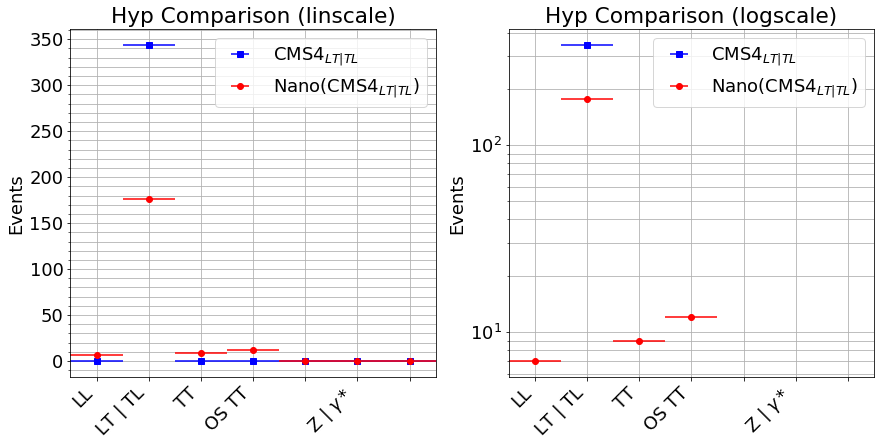

In [193]:
hyp_synch_plot(cms4_synch_df[cms4_synch_df.hyp_class == 2], 
               nano_synch_df[hyp2_synch_events],
               cms4_label=r"CMS4$_{LT|TL}$",
               nano_label=r"Nano(CMS4$_{LT|TL})$")

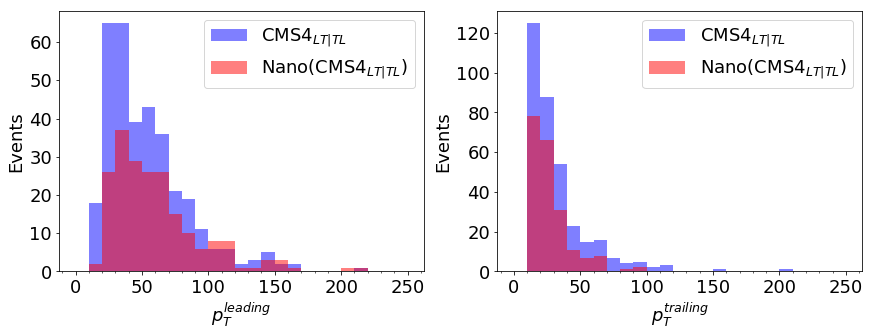

In [194]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=2,
            cms4_label=r"CMS4$_{LT|TL}$",
            nano_label=r"Nano(CMS4$_{LT|TL}$)")

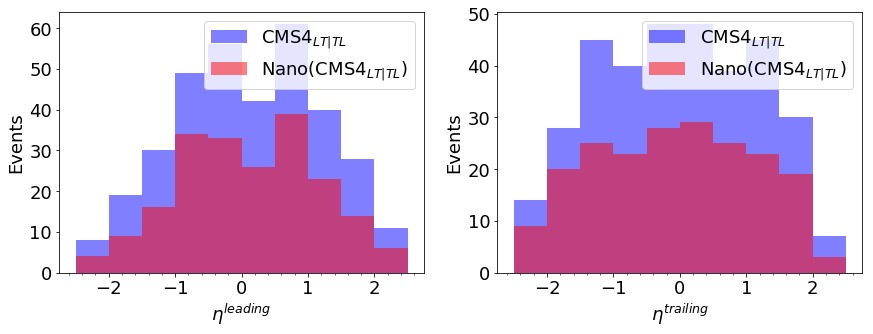

In [195]:
hyp_eta_plot(cms4_synch_df, nano_synch_df, hyp=2,
             cms4_label=r"CMS4$_{LT|TL}$",
             nano_label=r"Nano(CMS4$_{LT|TL}$)")

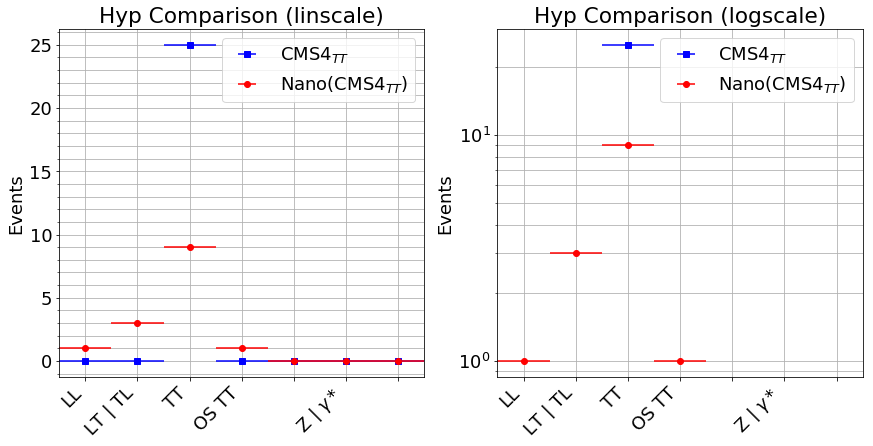

In [196]:
hyp_synch_plot(cms4_synch_df[cms4_synch_df.hyp_class == 3], 
               nano_synch_df[hyp3_synch_events],
               cms4_label=r"CMS4$_{TT}$",
               nano_label=r"Nano(CMS4$_{TT}$)")

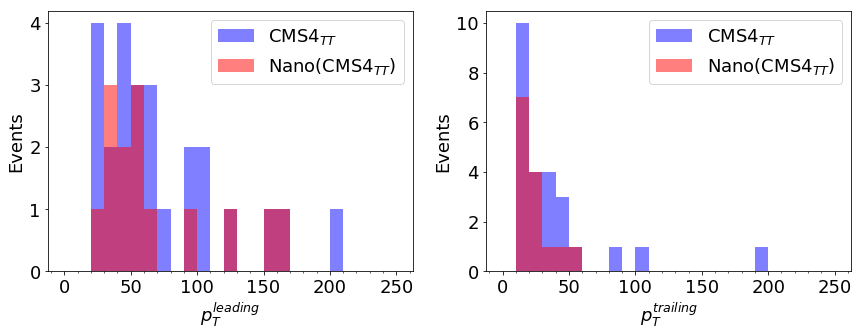

In [197]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=3,
            cms4_label=r"CMS4$_{TT}$",
            nano_label=r"Nano(CMS4$_{TT}$)")

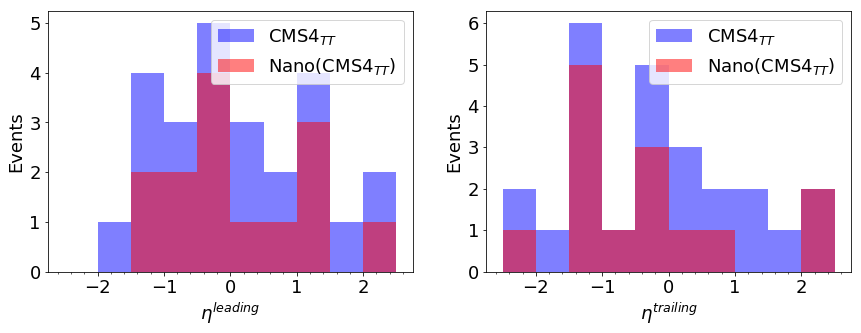

In [198]:
hyp_eta_plot(cms4_synch_df, nano_synch_df, hyp=3,
             cms4_label=r"CMS4$_{TT}$",
             nano_label=r"Nano(CMS4$_{TT}$)")

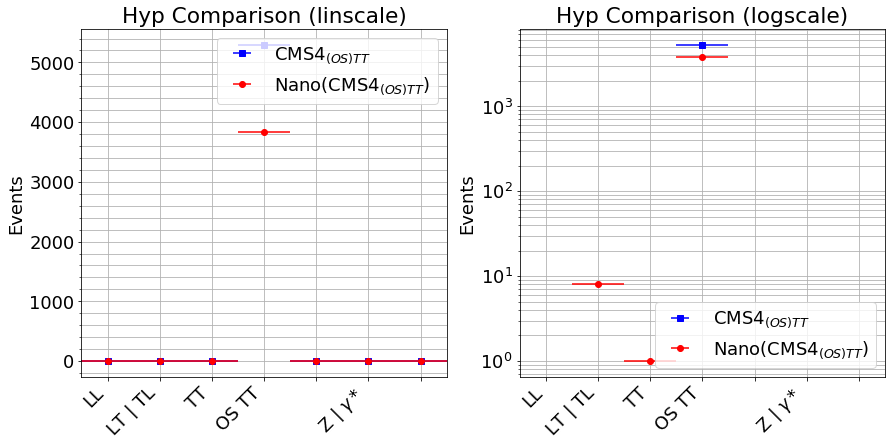

In [199]:
hyp_synch_plot(cms4_synch_df[cms4_synch_df.hyp_class == 4], 
               nano_synch_df[hyp4_synch_events],
               cms4_label=r"CMS4$_{(OS)TT}$",
               nano_label=r"Nano(CMS4$_{(OS)TT}$)")

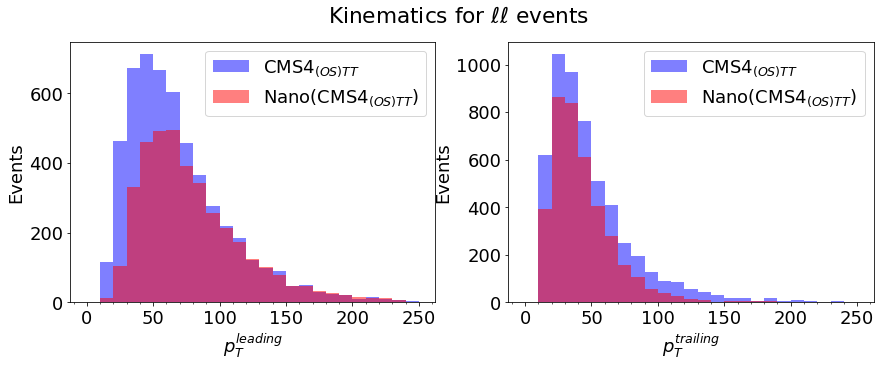

In [200]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=4,
            cms4_label=r"CMS4$_{(OS)TT}$",
            nano_label=r"Nano(CMS4$_{(OS)TT}$)",
            title=True)

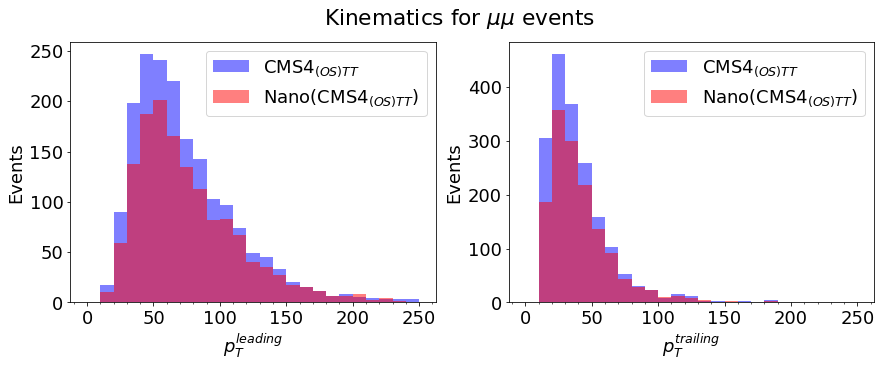

In [201]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=4, flav=(13,13),
            cms4_label=r"CMS4$_{(OS)TT}$",
            nano_label=r"Nano(CMS4$_{(OS)TT}$)",
            title=True)

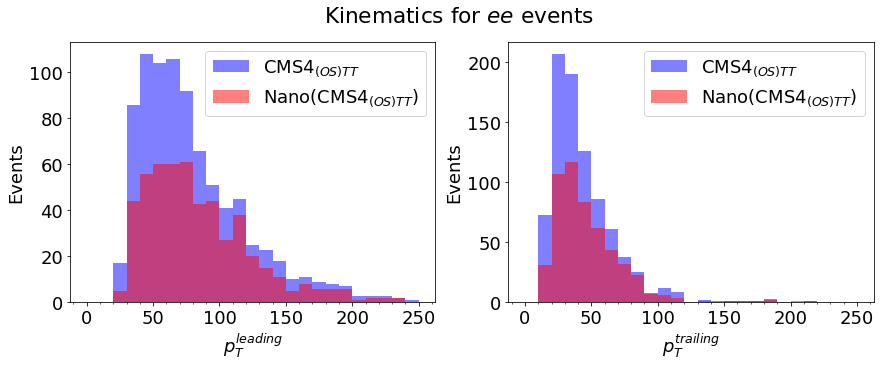

In [202]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=4, flav=(11,11),
            cms4_label=r"CMS4$_{(OS)TT}$",
            nano_label=r"Nano(CMS4$_{(OS)TT}$)",
            title=True)

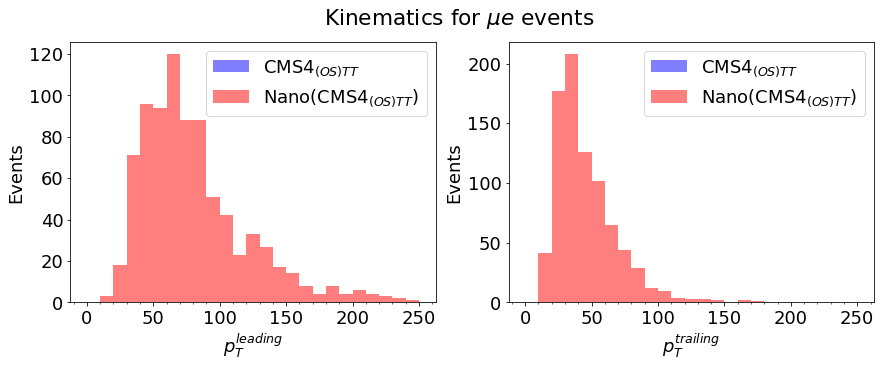

In [203]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=4, flav=(13,11),
            cms4_label=r"CMS4$_{(OS)TT}$",
            nano_label=r"Nano(CMS4$_{(OS)TT}$)",
            title=True)

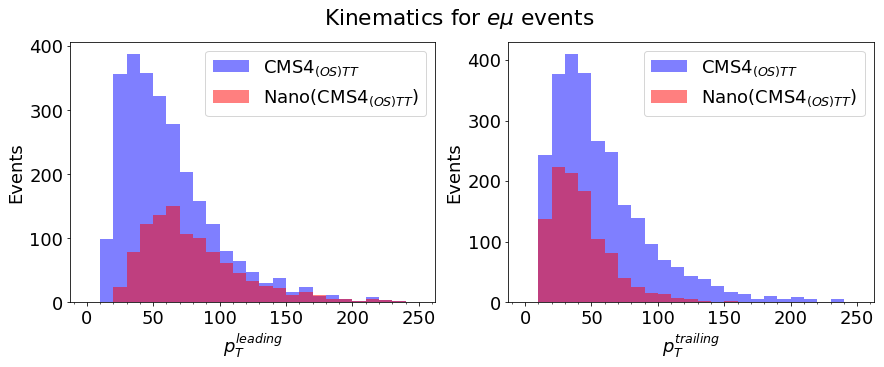

In [204]:
hyp_pt_plot(cms4_synch_df, nano_synch_df, hyp=4, flav=(11,13),
            cms4_label=r"CMS4$_{(OS)TT}$",
            nano_label=r"Nano(CMS4$_{(OS)TT}$)",
            title=True)

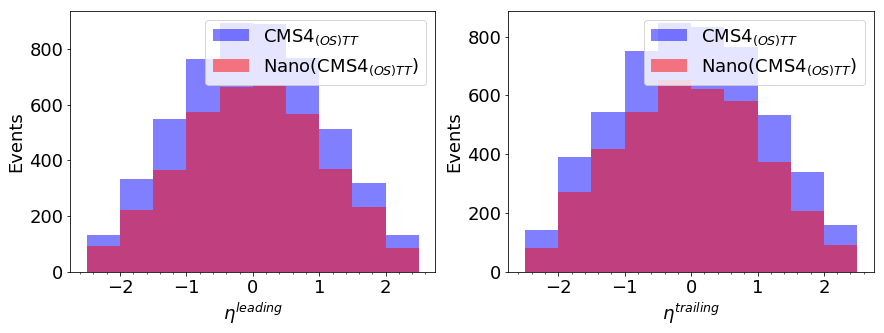

In [205]:
hyp_eta_plot(cms4_synch_df, nano_synch_df, hyp=4,
             cms4_label=r"CMS4$_{(OS)TT}$",
             nano_label=r"Nano(CMS4$_{(OS)TT}$)")

In [206]:
temp_df = nano_synch_df[hyp4_synch_events]

temp_df[temp_df.hyp_class == 2].sort_values("event")

,leader_eta,lagger_isTriggerSafe,leader_isTriggerSafe,lagger_id,leader_id,leader_is_loose,lagger_is_loose,leader_is_tight,lagger_is_tight,lagger_eta,hyp_class,leader_pt,lagger_pt,is_dilepton_event,event
entry,,,,,,,,,,,,,,,
33118,-0.413391,True,False,-11,-13,True,True,True,False,-0.081146,2,56.887234,25.220160,True,134649108
79462,0.075287,True,True,-11,-11,True,True,True,False,-0.461487,2,112.809364,17.312859,True,209208961
37584,0.046936,False,True,13,11,True,True,True,False,0.027081,2,19.011675,12.409923,True,209212074
23850,1.196289,False,False,13,13,True,True,True,False,-1.782959,2,39.772160,17.956148,True,213042500
24630,-1.752441,False,True,-13,-11,True,True,True,False,-0.800781,2,35.902866,12.529326,True,213044639
72005,1.317139,False,True,-13,-11,True,True,True,False,1.161133,2,45.027367,18.472599,True,426415456
8847,0.089279,False,True,-13,-11,True,True,False,True,1.437744,2,42.056767,17.764153,True,458255369
8995,0.952393,True,False,11,13,True,True,True,False,0.599365,2,62.796078,24.590025,True,458255917


In [207]:
cms4_synch_df[np.isin(cms4_synch_df.event, temp_df[temp_df.hyp_class == 2].event)].sort_values("event")

,leader_eta,lagger_isTriggerSafe,leader_isTriggerSafe,lagger_id,leader_id,lagger_idx,leader_idx,leader_is_loose,lagger_is_loose,leader_is_tight,lagger_is_tight,lagger_eta,hyp_class,leader_pt,lagger_pt,is_dilepton_event,event,run,lumi
entry,,,,,,,,,,,,,,,,,,,
172445,-0.413121,False,False,13,-13,1,0,True,True,True,True,1.673643,4,56.507320,32.095745,True,134649108,1,76483.0
204579,0.074978,False,True,13,-11,0,0,True,True,True,True,0.430373,4,112.227379,36.423603,True,209208961,1,118835.0
205696,-0.078637,True,True,11,-11,1,0,True,True,True,True,0.046758,4,57.288387,19.030516,True,209212074,1,118837.0
211410,-1.385651,False,False,13,-13,1,0,True,True,True,True,1.196033,4,47.716400,39.699856,True,213042500,1,121013.0
212198,-1.752370,True,True,11,-11,1,0,True,True,True,True,-0.685585,4,37.753773,32.097923,True,213044639,1,121013.0
168402,1.316836,False,True,13,-11,0,0,True,True,True,True,0.559215,4,45.126179,100.370842,True,426415456,1,242213.0
227565,1.649615,False,True,-13,11,0,1,True,True,True,True,1.437326,4,18.741495,17.741835,True,458255369,1,260299.0
227740,0.952587,False,False,-13,13,1,0,True,True,True,True,0.855184,4,63.172688,46.535336,True,458255917,1,260299.0


In [208]:
temp_df[temp_df.hyp_class != 4].sort_values("event")

,leader_eta,lagger_isTriggerSafe,leader_isTriggerSafe,lagger_id,leader_id,leader_is_loose,lagger_is_loose,leader_is_tight,lagger_is_tight,lagger_eta,hyp_class,leader_pt,lagger_pt,is_dilepton_event,event
entry,,,,,,,,,,,,,,,
49465,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,461260
49478,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,461303
49622,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,461762
49784,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,462181
50098,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,463268
50206,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,463532
50334,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,463863
50342,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,463879
50622,-999.0,False,False,-999,-999,False,False,False,False,-999.0,0,-999.0,-999.0,False,464702


In [209]:
cms4_synch_df[np.isin(cms4_synch_df.event, temp_df[temp_df.hyp_class != 4].event)].sort_values("event")

,leader_eta,lagger_isTriggerSafe,leader_isTriggerSafe,lagger_id,leader_id,lagger_idx,leader_idx,leader_is_loose,lagger_is_loose,leader_is_tight,lagger_is_tight,lagger_eta,hyp_class,leader_pt,lagger_pt,is_dilepton_event,event,run,lumi
entry,,,,,,,,,,,,,,,,,,,
182859,-0.069182,False,True,13,-11,0,0,True,True,True,True,1.894740,4,104.380608,10.103921,True,461260,1,263.0
182886,1.075717,False,False,13,-13,1,0,True,True,True,True,-1.834080,4,33.751511,30.911791,True,461303,1,263.0
183031,-1.763161,False,True,13,-11,0,0,True,True,True,True,-0.748644,4,218.316559,201.022644,True,461762,1,263.0
183177,0.058669,False,False,13,-13,1,0,True,True,True,True,2.216342,4,63.268448,59.204105,True,462181,1,263.0
183518,0.774724,False,False,-13,13,1,0,True,True,True,True,1.912000,4,80.826355,37.935051,True,463268,1,263.0
183617,-1.411144,False,False,-13,13,1,0,True,True,True,True,0.272332,4,41.488556,13.412524,True,463532,1,263.0
183739,-1.856412,False,False,13,-13,1,0,True,True,True,True,0.714680,4,42.758339,12.634783,True,463863,1,263.0
183751,-0.835403,False,False,-13,13,1,0,True,True,True,True,-2.231261,4,93.279434,13.232586,True,463879,1,263.0
184032,-0.428039,True,True,-11,11,1,0,True,True,True,True,-1.751446,4,102.272041,65.027153,True,464702,1,264.0
